In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, TimeDistributed, RepeatVector
from keras.layers import SimpleRNN, LSTM, GRU
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping

In [3]:
local_path_target = '/content/drive/MyDrive/Pessoal/LeWagon/predict_energy_generation/raw_data/hourly/energy_generation_data/df_deutschland.csv'

local_path_feature = "/content/drive/MyDrive/Pessoal/LeWagon/predict_energy_generation/raw_data/hourly/features/wind_hourly_clean.csv"

data_target = pd.read_csv(local_path_target)
data_target['Date'] = pd.to_datetime(data_target.Date)
data_target = data_target.groupby(by=data_target['Date']).sum()
wind_df = data_target[['Wind offshore[MWh]','Wind onshore[MWh]']].sum(axis=1)

data_feature = pd.read_csv(local_path_feature, index_col=0)
data_feature.index = pd.to_datetime(data_feature.index)
data_feature = pd.DataFrame(data_feature.mean(axis=1), columns=['wind_speed'])

In [4]:
complete_df = pd.concat([data_feature.iloc[:52608], wind_df.iloc[:-24]], axis= 1)
complete_df.rename(columns={0:'energy_production'}, inplace=True)
complete_df = complete_df[['energy_production', 'wind_speed']]

In [5]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(complete_df)

scaled_df = pd.DataFrame(scaled_df, columns=complete_df.columns)

In [6]:
def train_val_generators(mtx, data_size=0.5, val_size=0.18968, test_days=14, batch_days=14):
  init_idx = int(len(mtx) * (1 - data_size))
  val_idx = init_idx + int(((len(mtx) - init_idx) - (test_days * 24)) * (1 - val_size))
  #print(init_idx, val_idx)

  # Train_Data
  trainX = mtx[init_idx:val_idx,1:]
  trainy = mtx[init_idx:val_idx,0]
  # validation Data
  valX = mtx[val_idx:-test_days*24,1:]
  valy = mtx[val_idx:-test_days*24,0]
  # Test Data
  X_test = np.expand_dims(mtx[-test_days*24:,1:], axis=0)
  y_test = mtx[-test_days*24:,0]

  print(f'trainX.shape = {trainX.shape} , trainy.shape = {trainy.shape}')
  print(f'  valX.shape = {valX.shape}   ,   valy.shape = {valy.shape}')
  print(f'X_test.shape = {X_test.shape} , y_test.shape = {y_test.shape}')

  timesteps = batch_days * 24
  batch_size = 64

  train_generator = timeseries_dataset_from_array(trainX, trainy, sequence_length=timesteps, sampling_rate=1, batch_size=batch_size)
  validation_generator = timeseries_dataset_from_array(valX, valy, sequence_length=timesteps, sampling_rate=1, batch_size=batch_size)

  return train_generator, validation_generator, X_test, y_test

In [7]:
train_generator, validation_generator, X_test, y_test = train_val_generators(scaled_df.to_numpy(), data_size=0.1, 
                                                                             val_size=0.2, test_days=7, batch_days=7)

trainX.shape = (4074, 1) , trainy.shape = (4074,)
  valX.shape = (1019, 1)   ,   valy.shape = (1019,)
X_test.shape = (1, 168, 1) , y_test.shape = (168,)


# Baseline model

In [ ]:
def get_base_model():
  model = Sequential()
  model.add(LSTM(units=128, input_shape=(timesteps,1), return_sequences=True, activation='tanh'))
  #model.add(layers.LeakyReLU(alpha=0.5))
  #model.add(LSTM(128, return_sequences=True))
  #model.add(layers.Dropout(0.3))
  #model.add(layers.Dense(1))
  return model

base_model = get_base_model()

In [ ]:
base_model.compile(loss='mse', optimizer='rmsprop', metrics=['mae', "mse"])

# Complex model

In [8]:
timesteps = 14 * 24

def get_model():
  model = Sequential()
  model.add(LSTM(128,input_shape=(timesteps,1),return_sequences=True ))
  model.add(layers.LeakyReLU(alpha=0.5))
  model.add(LSTM(128, return_sequences=True))
  #model.add(layers.LeakyReLU(alpha=0.5))
  #model.add(layers.Dropout(0.3))
  #model.add(LSTM(128, return_sequences=False))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(1))
  return model

model_1 = get_model()

In [9]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 336, 128)          66560     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 336, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 336, 128)          131584    
_________________________________________________________________
dropout (Dropout)            (None, 336, 128)          0         
_________________________________________________________________
dense (Dense)                (None, 336, 1)            129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________


In [10]:
es = [EarlyStopping(monitor="val_loss", mode='min', patience = 11, restore_best_weights=True)] 
model_1.compile(loss='mse', optimizer='adam', metrics=['mae', "mse"])

history = model_1.fit(train_generator, validation_data=validation_generator, shuffle = False,  callbacks = es, epochs=100, verbose=2)

Epoch 1/100
62/62 - 25s - loss: 0.0120 - mae: 0.0838 - mse: 0.0120 - val_loss: 0.0339 - val_mae: 0.1567 - val_mse: 0.0339
Epoch 2/100
62/62 - 2s - loss: 0.0131 - mae: 0.0861 - mse: 0.0131 - val_loss: 0.0289 - val_mae: 0.1439 - val_mse: 0.0289
Epoch 3/100
62/62 - 2s - loss: 0.0119 - mae: 0.0830 - mse: 0.0119 - val_loss: 0.0239 - val_mae: 0.1307 - val_mse: 0.0239
Epoch 4/100
62/62 - 2s - loss: 0.0117 - mae: 0.0826 - mse: 0.0117 - val_loss: 0.0233 - val_mae: 0.1294 - val_mse: 0.0233
Epoch 5/100
62/62 - 2s - loss: 0.0119 - mae: 0.0834 - mse: 0.0119 - val_loss: 0.0330 - val_mae: 0.1558 - val_mse: 0.0330
Epoch 6/100
62/62 - 2s - loss: 0.0135 - mae: 0.0893 - mse: 0.0135 - val_loss: 0.0166 - val_mae: 0.1102 - val_mse: 0.0166
Epoch 7/100
62/62 - 2s - loss: 0.0140 - mae: 0.0937 - mse: 0.0140 - val_loss: 0.0141 - val_mae: 0.1001 - val_mse: 0.0141
Epoch 8/100
62/62 - 2s - loss: 0.0138 - mae: 0.0941 - mse: 0.0138 - val_loss: 0.0147 - val_mae: 0.1001 - val_mse: 0.0147
Epoch 9/100
62/62 - 2s - loss: 

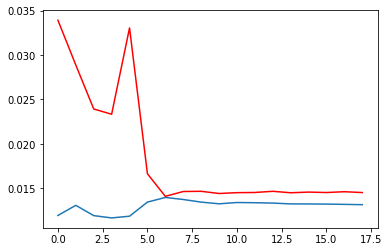

In [11]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"], color="red")

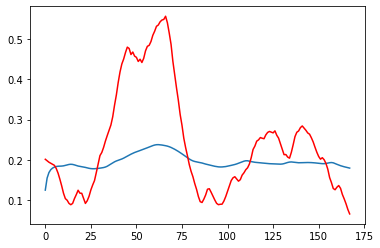

In [12]:
result = model_1.predict(X_test)
plt.plot(result.flatten())
plt.plot(y_test, color="red")

In [13]:
def mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sum(np.abs(y_true-y_pred))/(len(y_true))

def mse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean((y_true-y_pred)**2)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
mean_absolute_percentage_error(y_test, result.flatten())

41.71917893056979